In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation

In [6]:
# generates preprocessed datasets for our models

batchSize = 64
noiseDim = 200

loader1, loader2, loader_mix_val, vallabel, loader_mix_test, testlabel = preprocessing.gen_loaders(
    noiseDim, 
    batchSize
)

Spike generator training


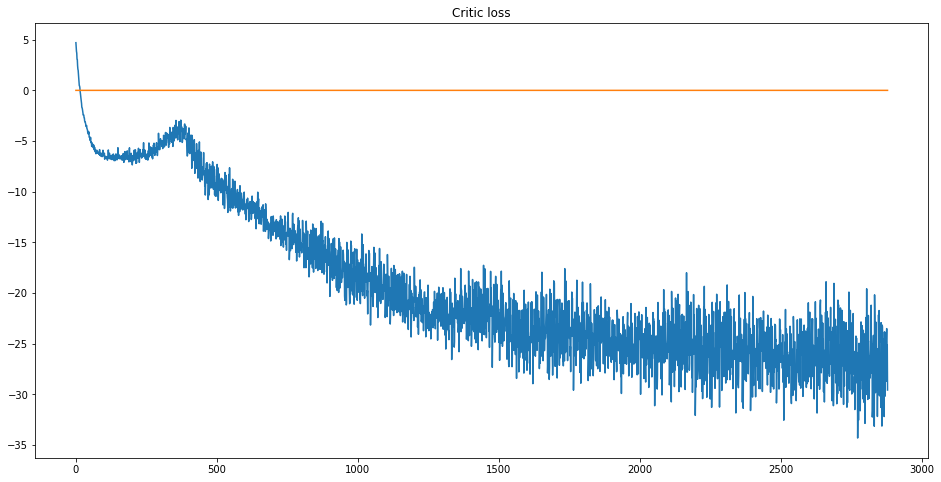

Critic loss -29.575145721435547

Epoch 19

Generated example:


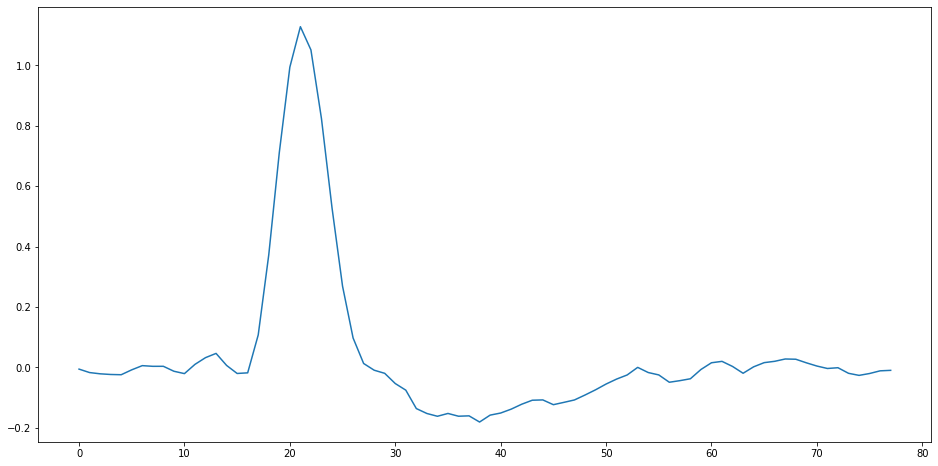

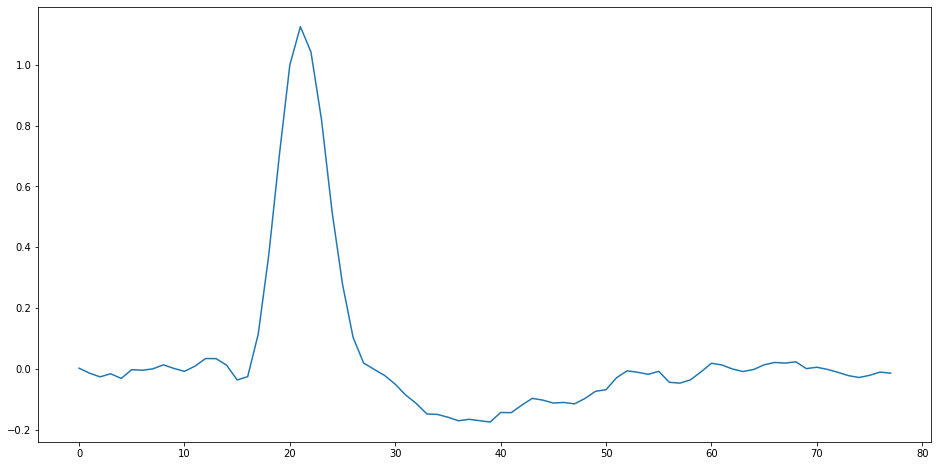

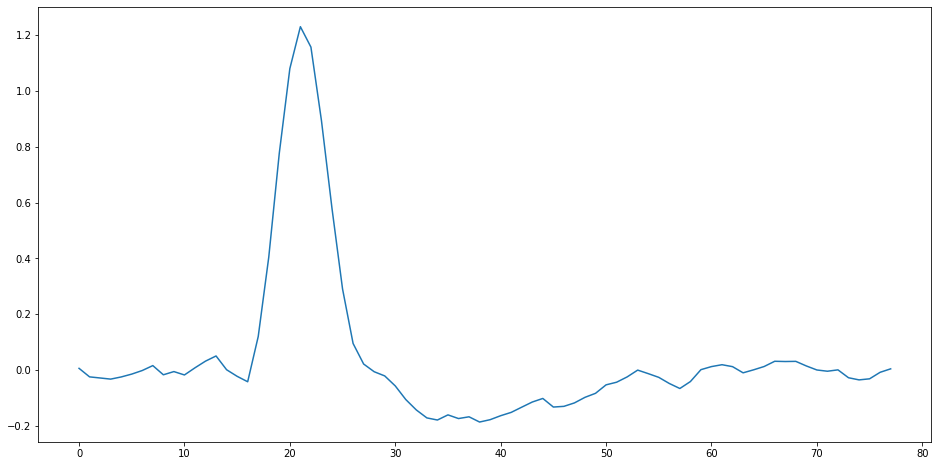

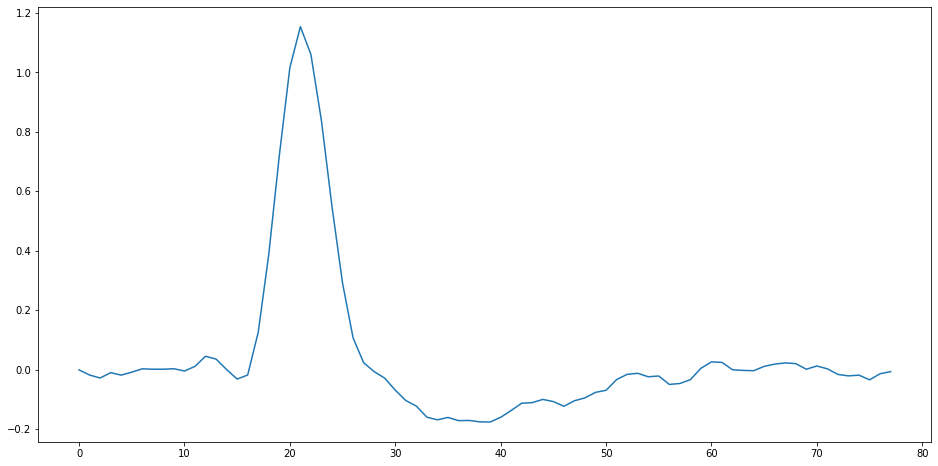

In [9]:
# declares and trains the gan for spikes 

gen1 = gans.Generator(inputSize=noiseDim, hiddenSize=40, outputSize=80)
critic1 = gans.Critic(inputSize=80, hiddenSize=40)

print("Spike generator training")

gans.adversarial_trainer( 
    train_loader = loader1,
    generator = gen1, 
    critic = critic1, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 20,
    printEpochs = 20,
)

Background generator training


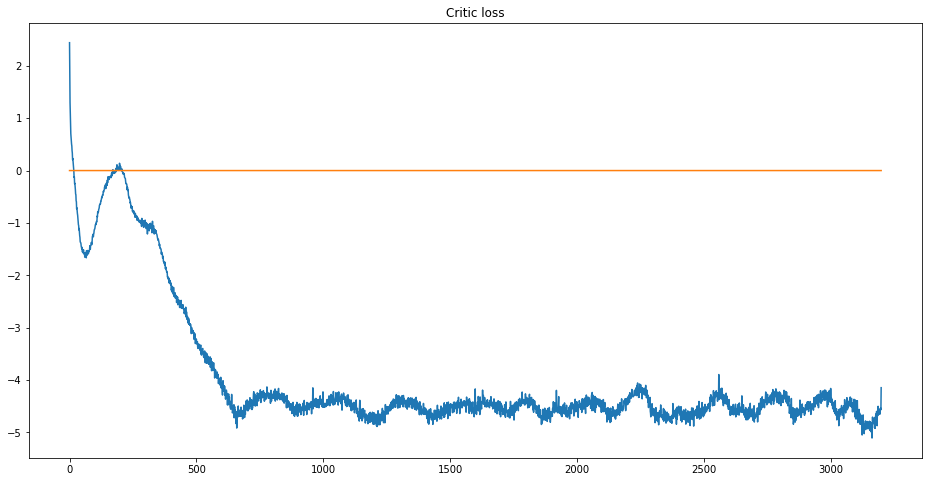

Critic loss -4.147559642791748

Epoch 9

Generated example:


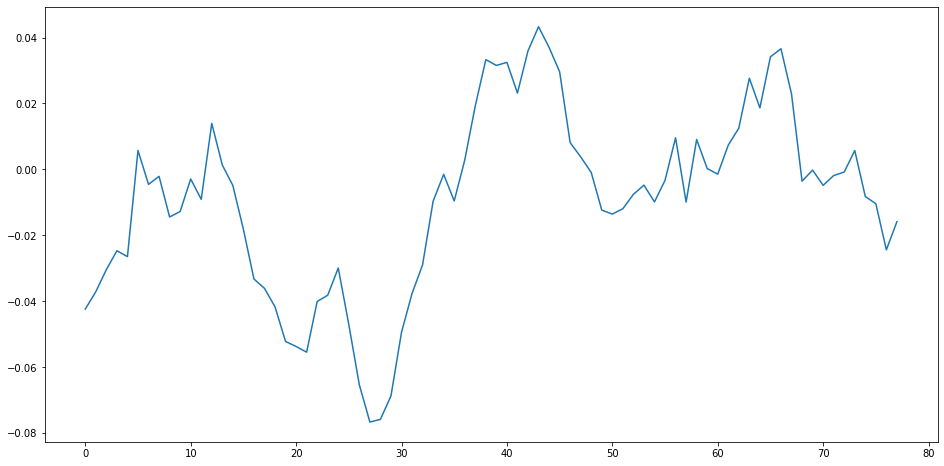

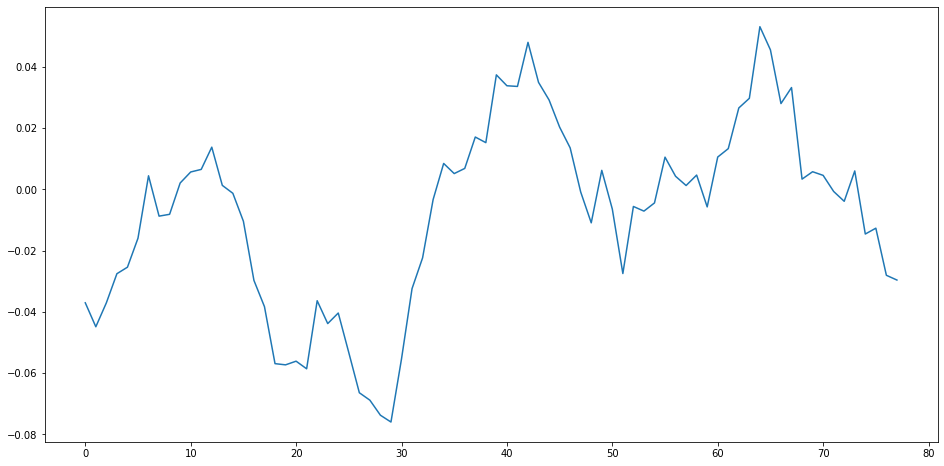

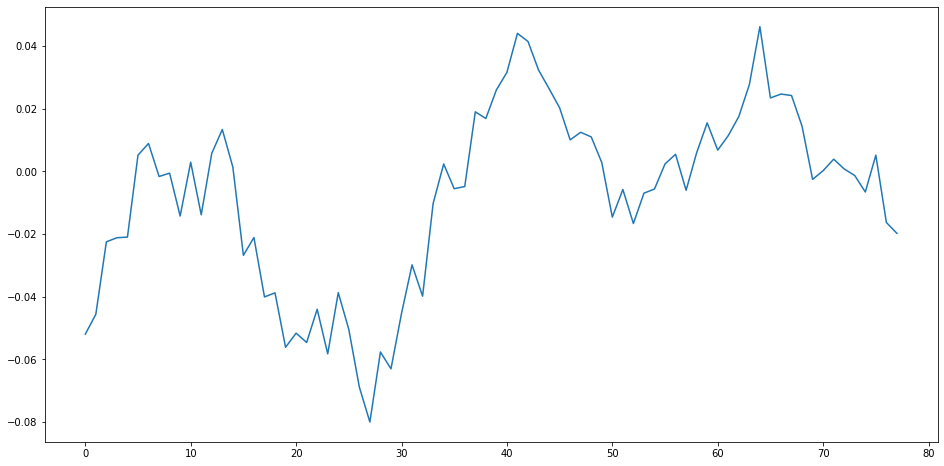

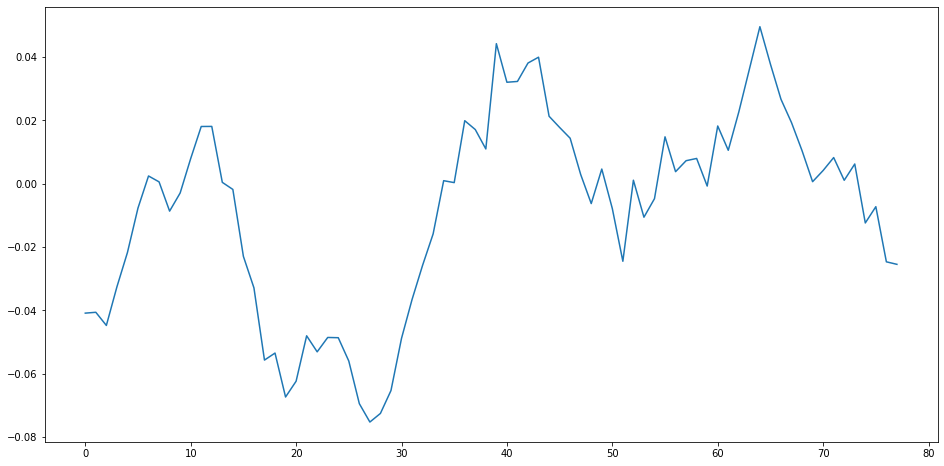

In [17]:
# declares and trains the gan for hash

gen2 = gans.Generator(inputSize=noiseDim, hiddenSize=40, outputSize=80)
critic2 = gans.Critic(inputSize=80, hiddenSize=40)
print("Background generator training")

gans.adversarial_trainer( 
    train_loader = loader2,
    generator = gen2, 
    critic = critic2, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 10,
    printEpochs = 10
)

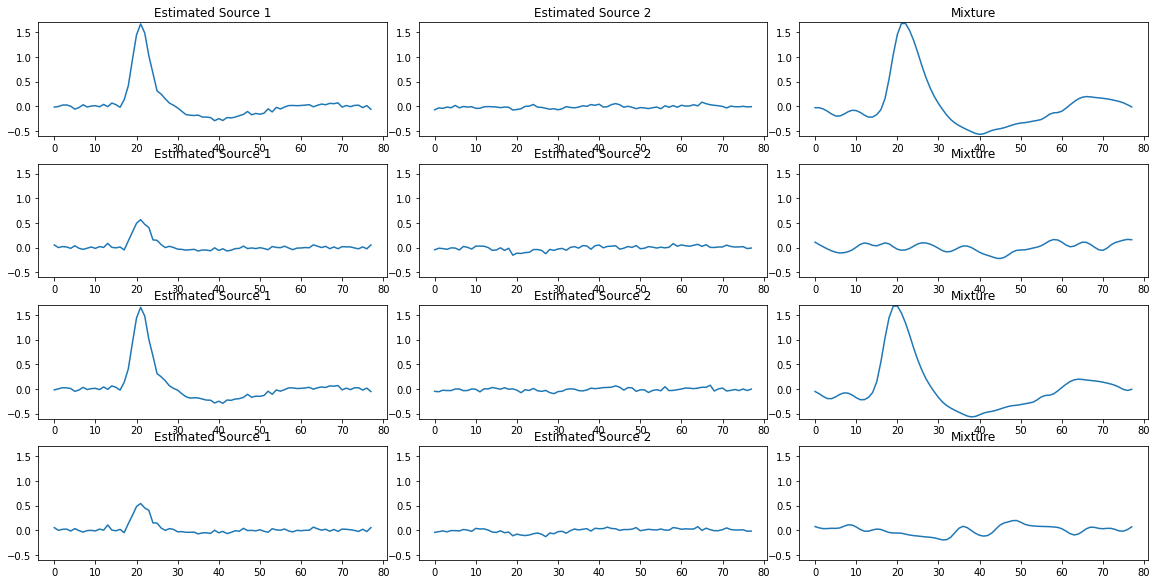

In [28]:
# separates the samples from loader_mix_val

(cleanextractedSpikesValidation,cleanextractedNoisesValidation) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=loader_mix_val,
    epochs=500
)

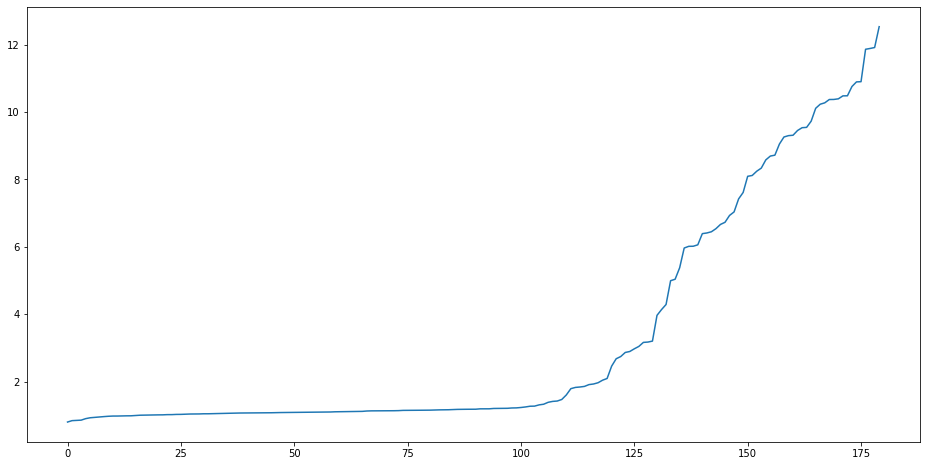

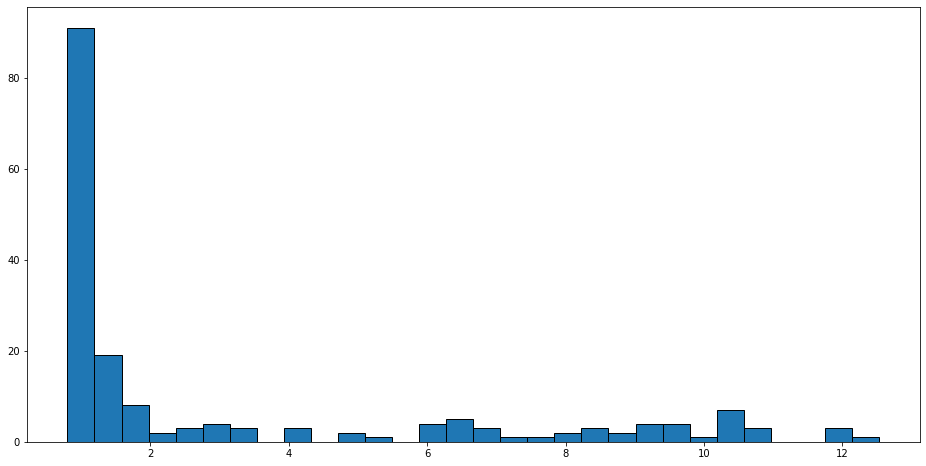

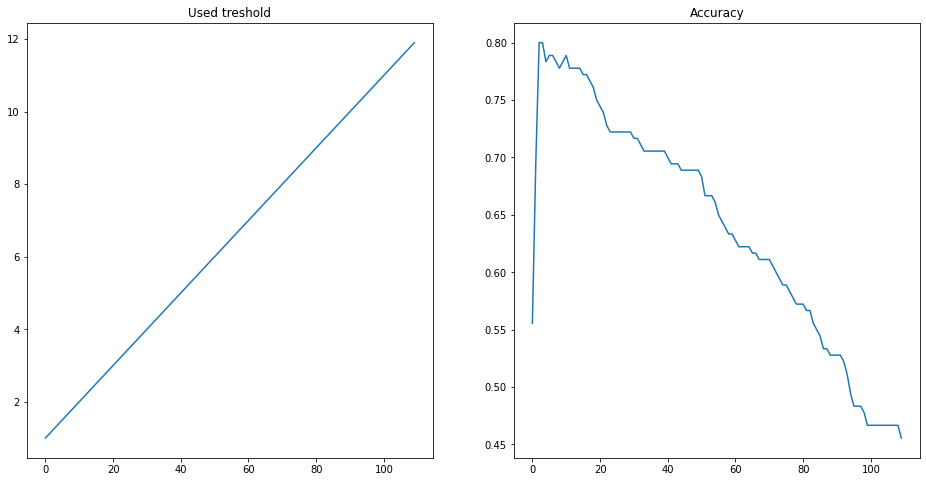

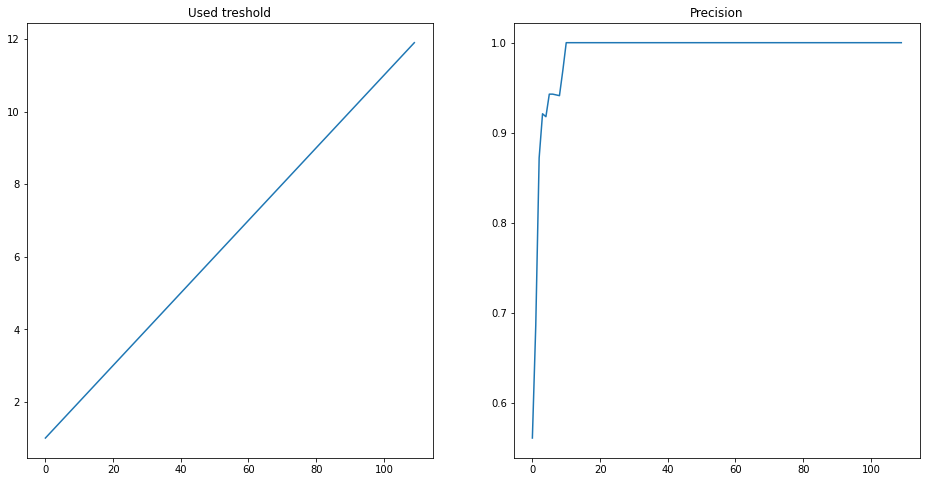

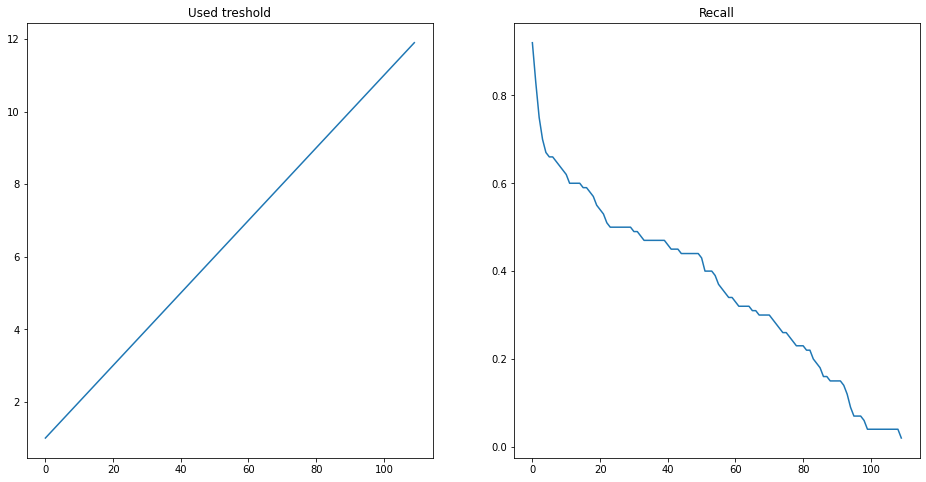

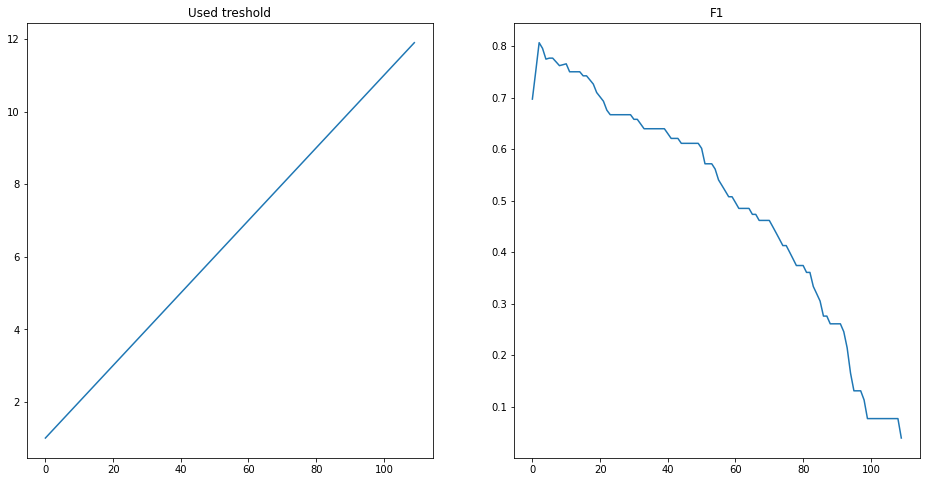

Threshold for best F1: 1.2
Threshold: 1.2
Precision: 0.872093023255814
Recall: 0.75
F1: 0.8064516129032259
Accuracy: 0.8


In [27]:
# some interpretation of results

import numpy as np
import torch
import matplotlib.pyplot as plt


extractedSpikesValidation = np.array(cleanextractedSpikesValidation)
energy = []

for extractedSpike in extractedSpikesValidation:
    energy.append(sum(np.power(extractedSpike, 2)))

energy = np.array(energy)
hist, edges = np.histogram(energy, bins = 30)

plt.plot(np.sort(energy))
plt.show()
plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor="black", align="edge")
plt.show()

thresholds =  [x / 10 for x in range(10,120,1)]

precisions = []
recalls = []
f1s = []
accs = []
used = []

for threshold in thresholds:
    try:
        res = []

        for elem in energy:
            if elem > threshold:
                res.append(1)
            else:
                res.append(0)

        truepos = 0
        falsepos = 0
        trueneg = 0
        falseneg = 0

        for i in range(0, len(vallabel)):
            if (
                vallabel[i] == 1 or 
                vallabel[i - 1] == 1 or 
                vallabel[i - 2] == 1 or 
                i + 1 < 180 and vallabel[i + 1] == 1 or 
                i + 2 < 180 and vallabel[i + 2] == 1
            ):
                if res[i] == 1:
                    truepos += 1
                else:
                    falseneg += 1
            else:
                if res[i] == 1:
                    falsepos += 1
                else:
                    trueneg += 1

        precision = truepos / (truepos + falsepos)
        recall = truepos / (truepos + falseneg)  
        f1 = 2 * ((precision * recall)/(precision+recall))
        acc = (truepos + trueneg) / len(vallabel)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accs.append(acc)
        used.append(threshold)
    except:
        continue
    
_, axs = plt.subplots(1,2)
axs[0].plot(used)
axs[0].title.set_text("Used treshold")
axs[1].plot(accs)
axs[1].title.set_text("Accuracy")
plt.show()
_, axs = plt.subplots(1,2)
axs[0].plot(used)
axs[0].title.set_text("Used treshold")
axs[1].plot(precisions)
axs[1].title.set_text("Precision")
plt.show()
_, axs = plt.subplots(1,2)
axs[0].plot(used)
axs[0].title.set_text("Used treshold")
axs[1].plot(recalls)
axs[1].title.set_text("Recall")
plt.show()
_, axs = plt.subplots(1,2)
axs[0].plot(used)
axs[0].title.set_text("Used treshold")
axs[1].plot(f1s)
axs[1].title.set_text("F1")
plt.show()

f1max = f1s[0]
maxI = 0

for i,f in enumerate(f1s):
    if f > f1max:
        maxI = i
        f1max = f
print("Threshold for best F1: {}".format(used[maxI]))
res = []
threshold = used[maxI]
print("Threshold: {}".format(threshold))

for elem in energy:
    if elem > threshold:
        res.append(1)
    else:
        res.append(0)

truepos = 0
falsepos = 0
trueneg = 0
falseneg = 0

for i in range(0, len(vallabel)):
    if (
        vallabel[i] == 1 or 
        vallabel[i - 1] == 1 or 
        vallabel[i - 2] == 1 or 
        i + 1 < 180 and vallabel[i + 1] == 1 or 
        i + 2 < 180 and vallabel[i + 2] == 1
    ):
        if res[i] == 1:
            truepos += 1
        else:
            falseneg += 1
    else:
        if res[i] == 1:
            falsepos += 1
        else:
            trueneg += 1

precision = truepos / (truepos + falsepos)
recall = truepos / (truepos + falseneg)  
f1 = 2 * ((precision * recall)/(precision+recall))
acc = (truepos + trueneg) / len(vallabel)

print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(f1))
print("Accuracy: {}".format(acc))